<a href="https://colab.research.google.com/github/boldasl/20_IT_PROJECT_009/blob/main/Differential_Amplifier_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Nov 15 02:13:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q seaborn
!pip install livelossplot

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from livelossplot import PlotLossesKeras
from statsmodels.stats.outliers_influence import variance_inflation_factor

from datetime import datetime

print(keras.__version__)

2.4.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
MAIN_PATH = "./drive/My Drive/Colab Notebooks/20-2_IT_PROJECT/diff_amp/"
MODEL_PATH = "model/"
RAW_PATH = "raw_data/"

In [ ]:
raw_dataset = pd.read_csv(MAIN_PATH + RAW_PATH + "raw_diff_amp_data1.csv", na_values='?')
dataset = raw_dataset.copy()
raw_dataset


,Iss,Av,BW,M0_M1_W,M2_M3_W
0,0.000001,44.58,1.090000e+08,4.000000e-07,4.000000e-07
1,0.000001,42.62,8.970000e+07,4.000000e-07,6.000000e-07
2,0.000001,43.59,7.350000e+07,4.000000e-07,8.000000e-07
3,0.000001,44.21,6.130000e+07,4.000000e-07,1.000000e-06
4,0.000001,44.01,5.410000e+07,4.000000e-07,1.200000e-06
...,...,...,...,...,...
721,0.000100,41.38,1.310000e+09,2.400000e-06,1.600000e-06
722,0.000100,41.59,1.240000e+09,2.400000e-06,1.800000e-06
723,0.000100,41.73,1.170000e+09,2.400000e-06,2.000000e-06
724,0.000100,41.80,1.120000e+09,2.400000e-06,2.200000e-06


In [ ]:
# m에서 um으로 단위 변경
dataset["M0_M1_W"] *= 10 ** 6
dataset["M2_M3_W"] *= 10 ** 6

In [ ]:
# dataset에서 NaN 값이 있는 행의 개수를 계산하고 삭제.
print(dataset.isna().sum())
dataset = dataset.dropna()

Iss        0
Av         0
BW         1
M0_M1_W    0
M2_M3_W    0
dtype: int64


In [ ]:
# 데이터셋 확인
dataset.describe()

,Iss,Av,BW,M0_M1_W,M2_M3_W
count,725.000000,725.000000,7.250000e+02,725.000000,725.000000
mean,0.000027,44.395793,5.791113e+08,1.401379,1.401379
std,0.000035,7.857898,7.128618e+08,0.632236,0.632236
min,0.000001,17.720000,2.210000e+07,0.400000,0.400000
25%,0.000003,40.290000,8.360000e+07,0.800000,0.800000
50%,0.000006,46.350000,2.850000e+08,1.400000,1.400000
75%,0.000040,50.650000,8.030000e+08,2.000000,2.000000
max,0.000100,54.920000,4.730000e+09,2.400000,2.400000


In [ ]:
# train dataset과 test dataset을 8:2 비율로 분리
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print("train_dataset row count:", train_dataset.shape[0])
print("test_dataset row count:", test_dataset.shape[0])


train_dataset row count: 580
test_dataset row count: 145


<Figure size 9216x9216 with 0 Axes>

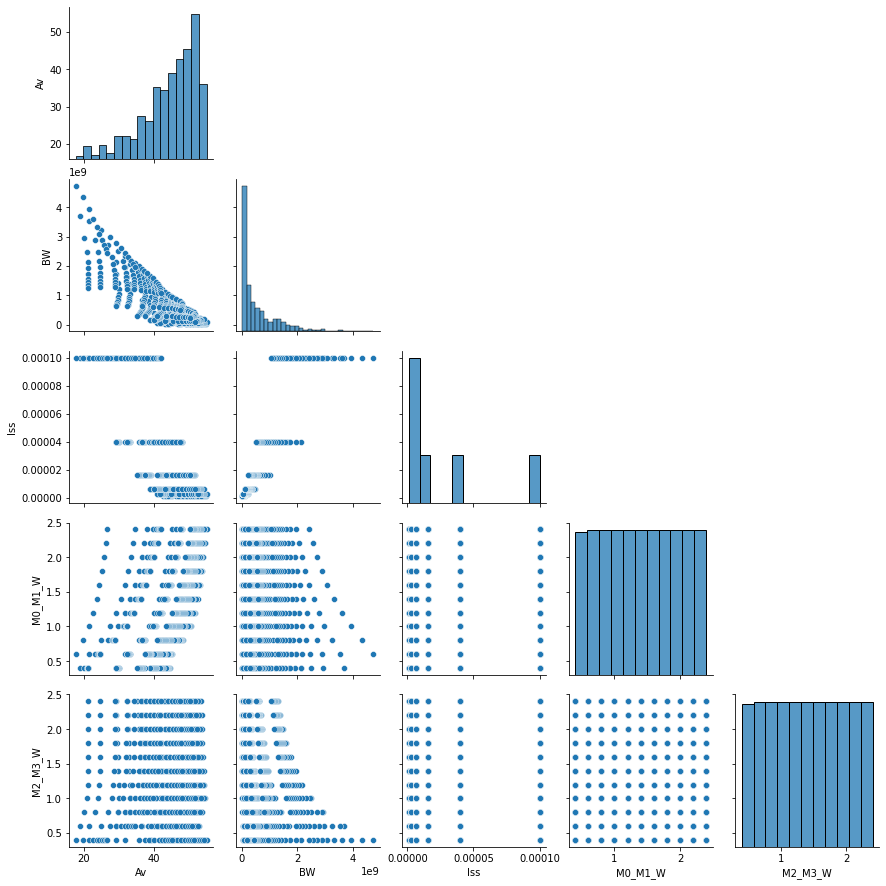

In [ ]:
# 산포도 확인
plt.figure(figsize=(128,128))
g = sns.pairplot(dataset[["Av", "BW", "Iss", "M0_M1_W", "M2_M3_W"]], diag_kind="auto")
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

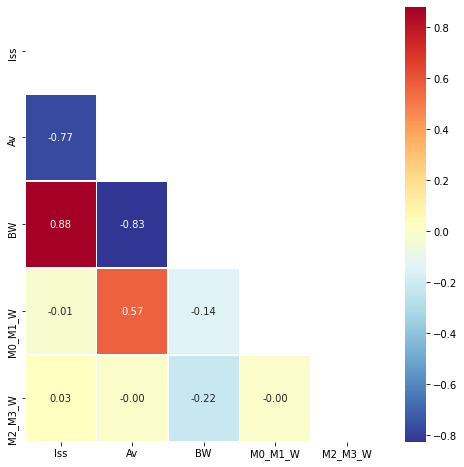

In [ ]:
# 피어슨 상관계수 확인
df = train_dataset.corr()
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,8))
sns.heatmap(df, annot=True, 
fmt = '.2f', linewidths=.5, cmap='RdYlBu_r', mask=mask)

In [ ]:
# 빈 DataFrame 생성.
train_labels = pd.DataFrame()
test_labels = pd.DataFrame()


In [ ]:
train_labels["M0_M1_W"] = train_dataset.pop("M0_M1_W")
train_labels["M2_M3_W"] = train_dataset.pop("M2_M3_W")

test_labels["M0_M1_W"] = test_dataset.pop("M0_M1_W")
test_labels["M2_M3_W"] = test_dataset.pop("M2_M3_W")


In [ ]:
# VIF 확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_dataset.values, i) for i in range(train_dataset.shape[1])]
vif["features"] = train_dataset.columns 
vif


,VIF Factor,features
0,7.199611,Iss
1,1.365130,Av
2,7.223499,BW


In [ ]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Iss,580.0,2.761938e-05,3.482885e-05,1.000000e-06,2.510000e-06,1.590000e-05,3.980000e-05,1.000000e-04
Av,580.0,4.443071e+01,7.898487e+00,1.772000e+01,4.028250e+01,4.641500e+01,5.077250e+01,5.492000e+01
BW,580.0,5.820669e+08,7.170952e+08,2.210000e+07,8.587500e+07,2.885000e+08,8.032500e+08,4.730000e+09


In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_dataset = norm(train_dataset)
normed_test_dataset = norm(test_dataset)

In [ ]:
normed_train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Iss,580.0,2.142730e-15,1.0,-0.764291,-0.720936,-0.336485,0.349728,2.078180
Av,580.0,4.290462e-15,1.0,-3.381750,-0.525190,0.251224,0.802912,1.328013
BW,580.0,-1.006857e-16,1.0,-0.780882,-0.691947,-0.409383,0.308443,5.784355


In [ ]:
# Network Configuration
LAMBDA = 0.0001

In [ ]:
# 인공지능 모델 생성.
def build_nn_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
    return model


def build_l2_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(LAMBDA), input_shape=[len(train_dataset.keys())]))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(LAMBDA)))
    model.add(Dense(2))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
    return model



In [ ]:
model = build_l2_model()
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 130       
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Traning Configuration
EPOCHS = 1000
BATCH_SIZE = 32

In [ ]:
# Define Callback Functions
early_stopping = EarlyStopping(monitor="val_loss", patience=30)
livelossplot = PlotLossesKeras() # 실시간으로 Loss Function 변화를 보여주는 Library


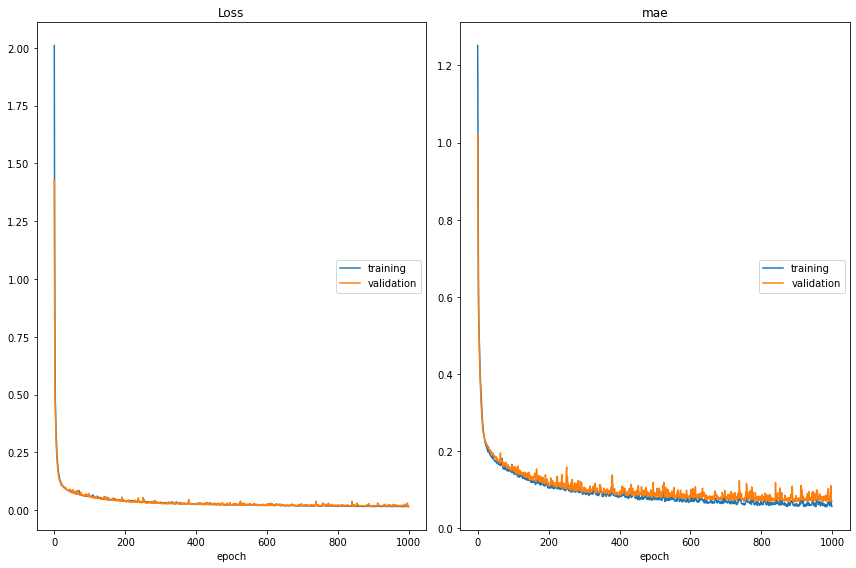

Loss
	training         	 (min:    0.014, max:    2.010, cur:    0.015)
	validation       	 (min:    0.017, max:    1.429, cur:    0.017)
mae
	training         	 (min:    0.056, max:    1.252, cur:    0.057)
	validation       	 (min:    0.068, max:    1.023, cur:    0.071)
14/14 [==============================] - 0s 28ms/step - loss: 0.0147 - mae: 0.0566 - val_loss: 0.0174 - val_mae: 0.0706
Epochs = 1000
INFO:tensorflow:Assets written to: ./drive/My Drive/Colab Notebooks/20-2_IT_PROJECT/diff_amp/model/epoch-1000_batch-32_time-2020-11-15 03:47:52.model/assets


In [ ]:
# Training Model
history = model.fit(
  normed_train_dataset, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25,
  callbacks=[livelossplot])

final_epochs = len(history.history["loss"])
print("Epochs =", final_epochs)

time = datetime.now()
now = "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(time.year, time.month, time.day, time.hour, time.minute, time.second)

# Save Model
MODEL_FILE_NAME = "epoch-{}_batch-{}_time-{}.model".format(final_epochs, BATCH_SIZE, now)
save_model(model, MAIN_PATH + MODEL_PATH + MODEL_FILE_NAME)


In [ ]:
# Load Model
model = load_model(MAIN_DIR + MODEL_PATH + "")

In [ ]:
# Evaluation
eval = model.evaluate(normed_test_dataset, test_labels, batch_size=1)

145/145 [==============================] - 0s 2ms/step - loss: 0.0210 - mae: 0.0707


In [ ]:
loss_hist = history.history["loss"]
val_loss_hist = history.history["val_loss"]


In [ ]:
example_batch = normed_train_dataset[:10]
example_result = model.predict(example_batch)
print(example_result) # 모델이 예측한 결과값
print(train_labels[:10]) # Ground Truth Value

[[1.7977449  2.206475  ]
 [0.59731245 0.7834914 ]
 [2.1317153  0.8430549 ]
 [2.108558   1.4303892 ]
 [0.5085027  1.4259043 ]
 [2.3163548  1.2558879 ]
 [2.097047   0.9611956 ]
 [1.267873   1.7793849 ]
 [0.9205159  1.8900015 ]
 [0.6622589  1.6134341 ]]
     M0_M1_W  M2_M3_W
570      1.8      2.2
497      0.6      0.8
585      2.2      0.8
456      2.0      1.4
258      0.6      1.4
235      2.4      1.2
575      2.0      1.0
40       1.0      1.8
31       0.8      2.2
14       0.6      1.0


In [ ]:
test_batch = normed_test_dataset
test_result = model.predict(test_batch)

In [ ]:
comparison = pd.DataFrame(columns=["Av", "BW", "Iss", "real_M0_M1_W", "M0_M1_W", "real_M2_M3_W", "M2_M3_W"])

In [ ]:
comparison["real_M0_M1_W"] = test_labels["M0_M1_W"]
comparison["real_M2_M3_W"] = test_labels["M2_M3_W"]
comparison["M0_M1_W"] = test_result[:, 0]
comparison["M2_M3_W"] = test_result[:, 1]

comparison["Av"] = test_dataset["Av"]
comparison["BW"] = test_dataset["BW"]
comparison["Iss"] = test_dataset["Iss"]


In [ ]:
TEST_RESULT_NAME = "test_result-{}.csv".format(now)
comparison.to_csv(MAIN_PATH + TEST_RESULT_NAME)
comparison


,Av,BW,Iss,real_M0_M1_W,M0_M1_W,real_M2_M3_W,M2_M3_W
9,43.30,3.360000e+07,0.000001,0.4,0.579215,2.2,1.892697
11,45.18,9.520000e+07,0.000001,0.6,0.602988,0.4,1.202914
19,44.11,3.570000e+07,0.000001,0.6,0.647602,2.0,1.864666
23,46.23,7.310000e+07,0.000001,0.8,0.750691,0.6,1.439945
28,47.39,3.960000e+07,0.000001,0.8,0.939474,1.6,1.800217
...,...,...,...,...,...,...,...
705,34.10,2.060000e+09,0.000100,2.2,1.666997,0.6,0.771848
706,37.28,1.830000e+09,0.000100,2.2,1.903159,0.8,0.860095
707,38.97,1.660000e+09,0.000100,2.2,2.101789,1.0,1.056483
708,39.76,1.530000e+09,0.000100,2.2,2.156371,1.2,1.237809
